In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import time

In [2]:
data=yf.download('^HSI','2020-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73155/72977215.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close
Date,,,,,
2020-01-02,28249.369141,28543.519531,28245.970703,28543.519531,28543.519531
2020-01-03,28828.359375,28883.300781,28428.169922,28451.500000,28451.500000
2020-01-06,28326.500000,28367.869141,28054.289062,28226.189453,28226.189453
2020-01-07,28352.679688,28473.080078,28264.070312,28322.060547,28322.060547
2020-01-08,27999.580078,28198.609375,27857.730469,28087.919922,28087.919922
...,...,...,...,...,...
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73155/1968958741.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])


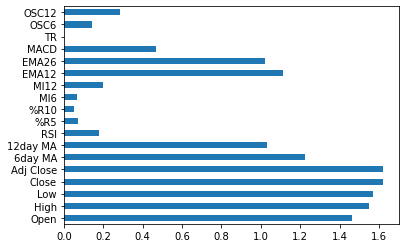

In [4]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(data.drop('Prediction',1),data['Prediction'])
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [5]:
data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73155/244261082.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)


,Open,High,Low,Close,Adj Close,6day MA,12day MA,EMA12,EMA26,MACD,Prediction
Date,,,,,,,,,,,
2021-12-23,23141.789062,23264.750000,23027.150391,23193.640625,23193.640625,23113.381836,23494.919108,23394.847996,23829.572972,-434.724976,23223.759766
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,23071.425130,23430.493327,23368.526730,23784.697920,-416.171190,23280.560547
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,23086.080078,23349.301758,23354.993471,23747.354411,-392.360940,23086.539062
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062,23143.026693,23273.536621,23313.692793,23698.405126,-384.712333,23112.009766
2021-12-30,23130.449219,23248.259766,22990.240234,23112.009766,23112.009766,23166.473307,23203.322428,23282.664635,23654.968432,-372.303797,23397.669922


In [6]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [7]:
# data['Prediction']=data['Close'].shift(-1)
# data.dropna(inplace=True)
# data_val=data[-100:]
# data=data[:-100]
# data_val.tail()

In [8]:
X=sc.fit_transform(data.drop('Prediction',1))
#X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(288, 1, 10) (288,) (73, 1, 10) (73,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73155/759405757.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [9]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
#     kernel_regularizer=regularizers.l2(0.01)
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-12 20:25:49.067872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 20:25:49.067996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
training_start=time.time()
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)
print("1000 Training takes --- %s seconds ---" % (time.time() - training_start))

Epoch 1/1000


2022-04-12 20:25:49.505489: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 20:25:50.708115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:25:50.914703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:25:50.953146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:25:51.022539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:25:51.086098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 2s 50ms/step - loss: 661546752.0000 - val_loss: 826603840.0000
Epoch 2/1000
 1/17 [>.............................] - ETA: 0s - loss: 677974912.0000

2022-04-12 20:25:51.773050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:25:51.857039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:25:51.881511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 0s 10ms/step - loss: 661524352.0000 - val_loss: 826591872.0000
Epoch 3/1000
17/17 [==============================] - 0s 10ms/step - loss: 661461696.0000 - val_loss: 826587840.0000
Epoch 4/1000
17/17 [==============================] - 0s 10ms/step - loss: 661221568.0000 - val_loss: 826623104.0000
Epoch 5/1000
17/17 [==============================] - 0s 10ms/step - loss: 660453312.0000 - val_loss: 826718976.0000
Epoch 6/1000
17/17 [==============================] - 0s 10ms/step - loss: 658996544.0000 - val_loss: 826803008.0000
Epoch 7/1000
17/17 [==============================] - 0s 11ms/step - loss: 657208704.0000 - val_loss: 826785216.0000
Epoch 8/1000
17/17 [==============================] - 0s 10ms/step - loss: 655270272.0000 - val_loss: 826516096.0000
Epoch 9/1000
17/17 [==============================] - 0s 10ms/step - loss: 653047808.0000 - val_loss: 825544576.0000
Epoch 10/1000
17/17 [==============================] - 0s 10ms/step - loss: 6

Epoch 141/1000
17/17 [==============================] - 0s 11ms/step - loss: 8242099.0000 - val_loss: 26654562.0000
Epoch 142/1000
17/17 [==============================] - 0s 10ms/step - loss: 7854290.0000 - val_loss: 25700254.0000
Epoch 143/1000
17/17 [==============================] - 0s 11ms/step - loss: 7495817.5000 - val_loss: 24792500.0000
Epoch 144/1000
17/17 [==============================] - 0s 10ms/step - loss: 7164916.5000 - val_loss: 23929386.0000
Epoch 145/1000
17/17 [==============================] - 0s 10ms/step - loss: 6859899.0000 - val_loss: 23108962.0000
Epoch 146/1000
17/17 [==============================] - 0s 12ms/step - loss: 6579135.5000 - val_loss: 22329446.0000
Epoch 147/1000
17/17 [==============================] - 0s 10ms/step - loss: 6321077.5000 - val_loss: 21589028.0000
Epoch 148/1000
17/17 [==============================] - 0s 11ms/step - loss: 6084234.0000 - val_loss: 20885962.0000
Epoch 149/1000
17/17 [==============================] - 0s 10ms/step - l

Epoch 212/1000
17/17 [==============================] - 0s 11ms/step - loss: 3934658.0000 - val_loss: 9008110.0000
Epoch 213/1000
17/17 [==============================] - 0s 11ms/step - loss: 3935374.5000 - val_loss: 8995693.0000
Epoch 214/1000
17/17 [==============================] - 0s 12ms/step - loss: 3936037.0000 - val_loss: 8984170.0000
Epoch 215/1000
17/17 [==============================] - 0s 11ms/step - loss: 3936643.7500 - val_loss: 8973477.0000
Epoch 216/1000
17/17 [==============================] - 0s 10ms/step - loss: 3937189.2500 - val_loss: 8963565.0000
Epoch 217/1000
17/17 [==============================] - 0s 10ms/step - loss: 3937663.0000 - val_loss: 8954378.0000
Epoch 218/1000
17/17 [==============================] - 0s 11ms/step - loss: 3938045.2500 - val_loss: 8945849.0000
Epoch 219/1000
17/17 [==============================] - 0s 10ms/step - loss: 3938301.5000 - val_loss: 8937928.0000
Epoch 220/1000
17/17 [==============================] - 0s 11ms/step - loss: 393

17/17 [==============================] - 0s 10ms/step - loss: 221167.2812 - val_loss: 136905.5156
Epoch 356/1000
17/17 [==============================] - 0s 10ms/step - loss: 219837.8750 - val_loss: 138815.1719
Epoch 357/1000
17/17 [==============================] - 0s 10ms/step - loss: 218548.8906 - val_loss: 140706.7656
Epoch 358/1000
17/17 [==============================] - 0s 10ms/step - loss: 217298.1875 - val_loss: 142574.7656
Epoch 359/1000
17/17 [==============================] - 0s 10ms/step - loss: 216084.3750 - val_loss: 144414.6094
Epoch 360/1000
17/17 [==============================] - 0s 11ms/step - loss: 214905.2500 - val_loss: 146222.7969
Epoch 361/1000
17/17 [==============================] - 0s 10ms/step - loss: 213758.8281 - val_loss: 147995.6094
Epoch 362/1000
17/17 [==============================] - 0s 10ms/step - loss: 212644.0781 - val_loss: 149727.8594
Epoch 363/1000
17/17 [==============================] - 0s 10ms/step - loss: 211558.4062 - val_loss: 151418.359

Epoch 500/1000
17/17 [==============================] - 0s 10ms/step - loss: 143123.1250 - val_loss: 115252.8672
Epoch 501/1000
17/17 [==============================] - 0s 10ms/step - loss: 142882.0469 - val_loss: 115513.2578
Epoch 502/1000
17/17 [==============================] - 0s 10ms/step - loss: 142643.5625 - val_loss: 115757.5859
Epoch 503/1000
17/17 [==============================] - 0s 10ms/step - loss: 142407.4219 - val_loss: 115984.6484
Epoch 504/1000
17/17 [==============================] - 0s 10ms/step - loss: 142173.9844 - val_loss: 116195.5781
Epoch 505/1000
17/17 [==============================] - 0s 10ms/step - loss: 141943.0781 - val_loss: 116390.5781
Epoch 506/1000
17/17 [==============================] - 0s 11ms/step - loss: 141714.1406 - val_loss: 116568.1797
Epoch 507/1000
17/17 [==============================] - 0s 10ms/step - loss: 141487.5469 - val_loss: 116731.4453
Epoch 508/1000
17/17 [==============================] - 0s 10ms/step - loss: 141263.1094 - val_l

17/17 [==============================] - 0s 10ms/step - loss: 122089.7812 - val_loss: 104559.0625
Epoch 645/1000
17/17 [==============================] - 0s 10ms/step - loss: 122021.0859 - val_loss: 104565.5547
Epoch 646/1000
17/17 [==============================] - 0s 10ms/step - loss: 121952.6719 - val_loss: 104573.6953
Epoch 647/1000
17/17 [==============================] - 0s 10ms/step - loss: 121884.5703 - val_loss: 104584.1562
Epoch 648/1000
17/17 [==============================] - 0s 10ms/step - loss: 121816.9141 - val_loss: 104597.1406
Epoch 649/1000
17/17 [==============================] - 0s 10ms/step - loss: 121749.4219 - val_loss: 104611.5312
Epoch 650/1000
17/17 [==============================] - 0s 10ms/step - loss: 121682.3750 - val_loss: 104628.8984
Epoch 651/1000
17/17 [==============================] - 0s 10ms/step - loss: 121615.6172 - val_loss: 104647.7422
Epoch 652/1000
17/17 [==============================] - 0s 10ms/step - loss: 121548.8984 - val_loss: 104668.859

Epoch 789/1000
17/17 [==============================] - 0s 11ms/step - loss: 119189.9531 - val_loss: 114424.7422
Epoch 790/1000
17/17 [==============================] - 0s 10ms/step - loss: 124385.9297 - val_loss: 113528.1875
Epoch 791/1000
17/17 [==============================] - 0s 10ms/step - loss: 117182.9297 - val_loss: 118879.2578
Epoch 792/1000
17/17 [==============================] - 0s 9ms/step - loss: 121705.4453 - val_loss: 115102.2266
Epoch 793/1000
17/17 [==============================] - 0s 10ms/step - loss: 119105.7344 - val_loss: 124361.4219
Epoch 794/1000
17/17 [==============================] - 0s 9ms/step - loss: 121696.3203 - val_loss: 115625.5547
Epoch 795/1000
17/17 [==============================] - 0s 9ms/step - loss: 122382.5781 - val_loss: 122706.2422
Epoch 796/1000
17/17 [==============================] - 0s 11ms/step - loss: 121224.4297 - val_loss: 114320.1953
Epoch 797/1000
17/17 [==============================] - 0s 9ms/step - loss: 125972.7344 - val_loss:

Epoch 862/1000
17/17 [==============================] - 0s 9ms/step - loss: 116338.2578 - val_loss: 121986.3984
Epoch 863/1000
17/17 [==============================] - 0s 9ms/step - loss: 122261.4688 - val_loss: 119833.9531
Epoch 864/1000
17/17 [==============================] - 0s 10ms/step - loss: 116253.5938 - val_loss: 128970.5234
Epoch 865/1000
17/17 [==============================] - 0s 10ms/step - loss: 120762.4297 - val_loss: 122203.2266
Epoch 866/1000
17/17 [==============================] - 0s 9ms/step - loss: 119267.7969 - val_loss: 132518.5625
Epoch 867/1000
17/17 [==============================] - 0s 9ms/step - loss: 119979.2266 - val_loss: 120597.0625
Epoch 868/1000
17/17 [==============================] - 0s 9ms/step - loss: 122160.7344 - val_loss: 124796.0000
Epoch 869/1000
17/17 [==============================] - 0s 10ms/step - loss: 117631.3047 - val_loss: 120970.2188
Epoch 870/1000
17/17 [==============================] - 0s 10ms/step - loss: 123851.8047 - val_loss: 

2022-04-12 20:28:50.824202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:28:50.896921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 20:28:50.969127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000 Training takes --- 181.57018184661865 seconds ---


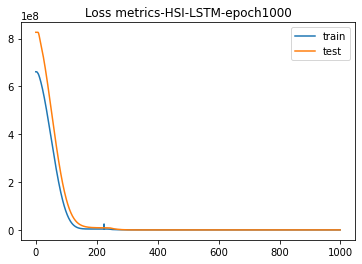

In [22]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.title('Loss metrics-HSI-LSTM-epoch1000')
plt.legend()

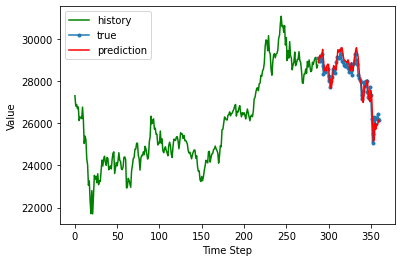

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

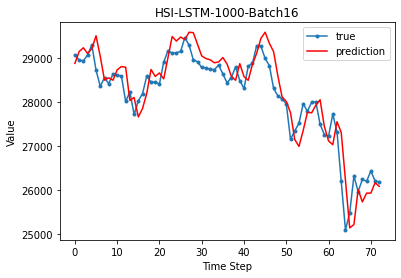

In [13]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-1000-Batch16')
plt.legend()
plt.show();

In [14]:
r2_score(y_test,y_pred)

0.8282066661481455

In [15]:
mean_absolute_percentage_error(y_test,y_pred)

0.011852283319080132

In [16]:
mean_squared_error(y_test,y_pred,squared=False)

419.330472764113

In [17]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_73155/2175021245.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


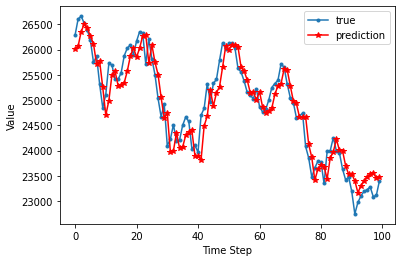

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [19]:
r2_score(y_val,y_val_pred)

0.8915184462422514

In [20]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.01121533605384016

In [21]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

330.8627942436726

## 